In [ ]:
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Step 1: Read and explore the data

In [2]:
# read text file into pandas DataFrame
# International airline passengers: monthly totals in thousands
df = pd.read_csv("AirPassengers.csv")
df.head(10)

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
5,1949-06,135
6,1949-07,148
7,1949-08,148
8,1949-09,136
9,1949-10,119


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Month        144 non-null    object
 1   #Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


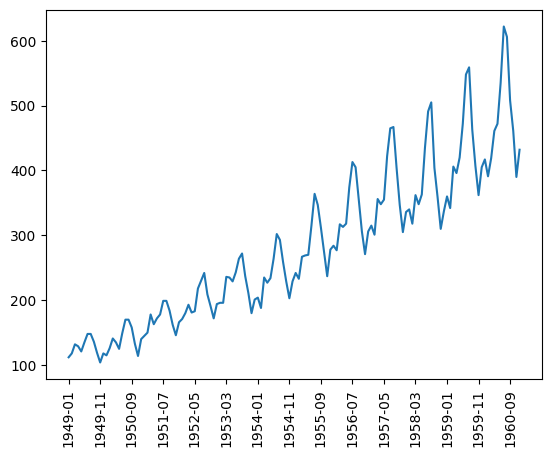

In [4]:
plt.plot(df['Month'], df['#Passengers'])

#to prevent overlap of labels on x axis display only every 10th value
plt.xticks(range(0, len(list(df['Month'])), 10), list(df['Month'])[::10], rotation=90)
plt.show()

# Step 2: Time series decompostion into seasonality and trend

In [5]:
# Convert the 'Date' column to datetime and set it as the index
data = df.copy()
data['Month'] = pd.to_datetime(data['Month'])
data.set_index('Month', inplace=True)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


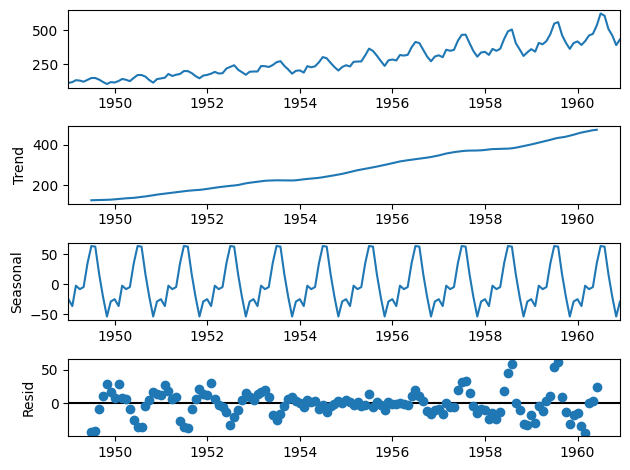

In [7]:
components = seasonal_decompose(data, model='additive')
components.plot()
plt.show()

# Step 3: Check for stationarity and convert to stationary

In [8]:
# null hypothesis : Time series is NOT stationary
result = adfuller(data)
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: 0.8153688792060543
p-value: 0.9918802434376411


In [9]:
data_copy = data.copy()
# Make the time series stationary by differencing - tried first order differentiation then second order
data['Stationary_Value'] = data['#Passengers'] - data['#Passengers'].shift(2)

print(data.head())


            #Passengers  Stationary_Value
Month                                    
1949-01-01          112               NaN
1949-02-01          118               NaN
1949-03-01          132              20.0
1949-04-01          129              11.0
1949-05-01          121             -11.0


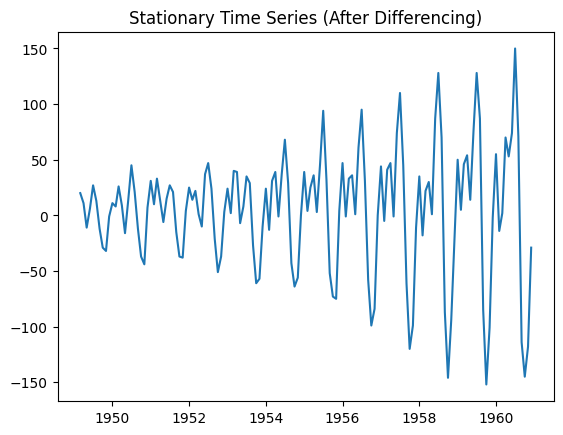

ADF Statistic: -2.9616951355554337
p-value: 0.03862975767698742


In [10]:

# Drop the first row with NaN values
data.dropna(inplace=True)

# Plot the differenced time series
plt.plot(data['Stationary_Value'])
plt.title('Stationary Time Series (After Differencing)')
plt.show()

# Perform ADF test on the differenced time series
result = adfuller(data['Stationary_Value'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

In [11]:
data = data_copy.copy()

# Apply log transformation before differencing
data['Log_Value'] = np.log1p(data['#Passengers'])
data['Log_Diff'] = data['Log_Value'] - data['Log_Value'].shift(2)
data.dropna(inplace=True)

# Perform ADF test on the differenced time series
result = adfuller(data['Log_Diff'], autolag='AIC')
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -3.170810056310465
p-value: 0.021737710264432986


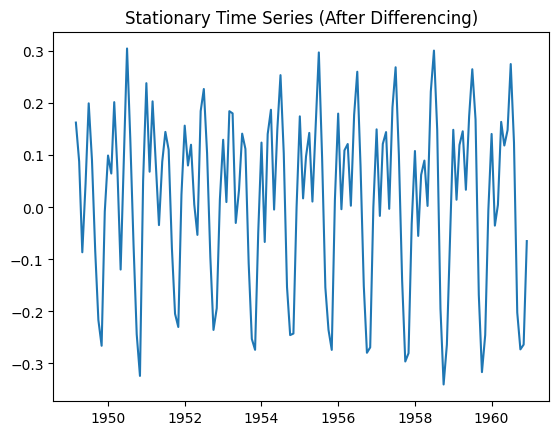

In [12]:
# Plot the differenced time series
plt.plot(data['Log_Diff'])
plt.title('Stationary Time Series (After Differencing)')
plt.show()

# Step 4: Fit Auto-Arima model with seasonaity set to true

In [15]:
series=df['#Passengers'] # Creating the Series
train=series[:-24]
test=series[-24:] # last 2 years of data to evaluate the model

In [16]:
help(pm.auto_arima)

Help on function auto_arima in module pmdarima.arima.auto:

auto_arima(y, X=None, start_p=2, d=None, start_q=2, max_p=5, max_d=2, max_q=5, start_P=1, D=None, start_Q=1, max_P=2, max_D=1, max_Q=2, max_order=5, m=1, seasonal=True, stationary=False, information_criterion='aic', alpha=0.05, test='kpss', seasonal_test='ocsb', stepwise=True, n_jobs=1, start_params=None, trend=None, method='lbfgs', maxiter=50, offset_test_args=None, seasonal_test_args=None, suppress_warnings=True, error_action='trace', trace=False, random=False, random_state=None, n_fits=10, return_valid_fits=False, out_of_sample_size=0, scoring='mse', scoring_args=None, with_intercept='auto', sarimax_kwargs=None, **fit_args)
    Automatically discover the optimal order for an ARIMA model.
    
    The auto-ARIMA process seeks to identify the most optimal
    parameters for an ``ARIMA`` model, settling on a single fitted ARIMA model.
    This process is based on the commonly-used R function,
    ``forecast::auto.arima`` [3].


In [ ]:

model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p=3 and q=3
                      m=12,              # periodicity of 12 as the data timeline is in months / yearly seasonality
                      d=None,           # let the model determine 'd'
                      seasonal=True,   # Seasonality
                      exogenous= None, # pass other dependant features over here
                      start_P=0, 
                      D=None, # differencing parameter
                      trace=True, # Whether to print status on the fits
                      error_action='ignore',  
                      suppress_warnings=True)
print(model.summary())



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=806.570, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=807.655, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=804.973, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=805.408, Time=0.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=803.281, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=805.044, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=0.42 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=805.093, Time=0.06 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=804.813, Time=0.06 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=803.650, Time=0.03 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=806.793, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=805.281, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 1.242 seconds
                                     SARIMAX Results                                      


# Step 5: Evaluate the model on test data

In [20]:
# 2 years out - traffic after 2 years 
# lstm: traffic of all past years till 2 years in past: 2010 - 2012

val_forecast = model.predict(n_periods=len(test))

# creating series from the prediction array
val_forecast=pd.Series(val_forecast,index=test.index)

# Errors
errors_auto=errors(val_forecast,test)
errors_auto

{'mae': 68.57726547031133,
 'mape': 14.927552691246468,
 'rmse': 74.25222000478917}

In [21]:
{'mae': 68.57726547031133,
 'mape': 0.14927552691246468,
 'rmse': 74.25222000478917}

{'mae': 68.57726547031133,
 'mape': 0.14927552691246468,
 'rmse': 74.25222000478917}

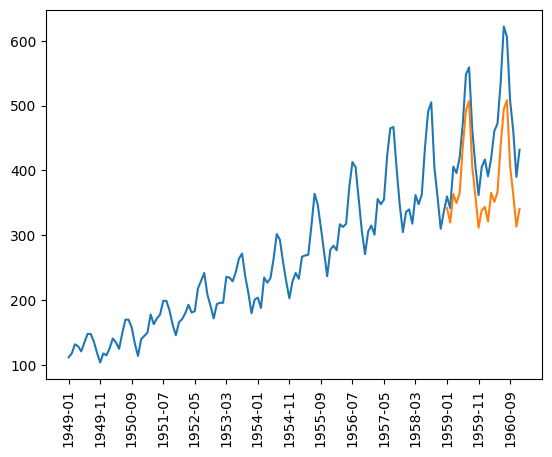

In [22]:
# Plot predicted time series on actual data

plt.plot(df['Month'], df['#Passengers'])
#to prevent overlap of labels on x axis display only every 10th value
plt.xticks(range(0, len(list(df['Month'])), 10), list(df['Month'])[::10], rotation=90)

plt.plot(df['Month'][-24:], val_forecast)
plt.show()

# Step 6: Predict the passangers for next 3 years


In [23]:
model.get_params()

{'maxiter': 50,
 'method': 'lbfgs',
 'order': (1, 1, 0),
 'out_of_sample_size': 0,
 'scoring': 'mse',
 'scoring_args': {},
 'seasonal_order': (0, 1, 0, 12),
 'start_params': None,
 'suppress_warnings': True,
 'trend': None,
 'with_intercept': False}

In [24]:
model.fit(series)

ARIMA(order=(1, 1, 0), scoring_args={}, seasonal_order=(0, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [25]:
from pandas.tseries.offsets import DateOffset
n_periods=36 # Forecasting next 36 months
forecast = model.predict(n_periods=n_periods)
forecast

144    444.307609
145    418.212986
146    446.242093
147    488.233139
148    499.235893
149    562.235046
150    649.235307
151    633.235226
152    535.235251
153    488.235244
154    417.235246
155    459.235245
156    471.542854
157    445.448231
158    473.477338
159    515.468384
160    526.471139
161    589.470291
162    676.470552
163    660.470472
164    562.470496
165    515.470489
166    444.470491
167    486.470490
168    498.778100
169    472.683476
170    500.712583
171    542.703630
172    553.706384
173    616.705537
174    703.705797
175    687.705717
176    589.705742
177    542.705734
178    471.705736
179    513.705736
dtype: float64

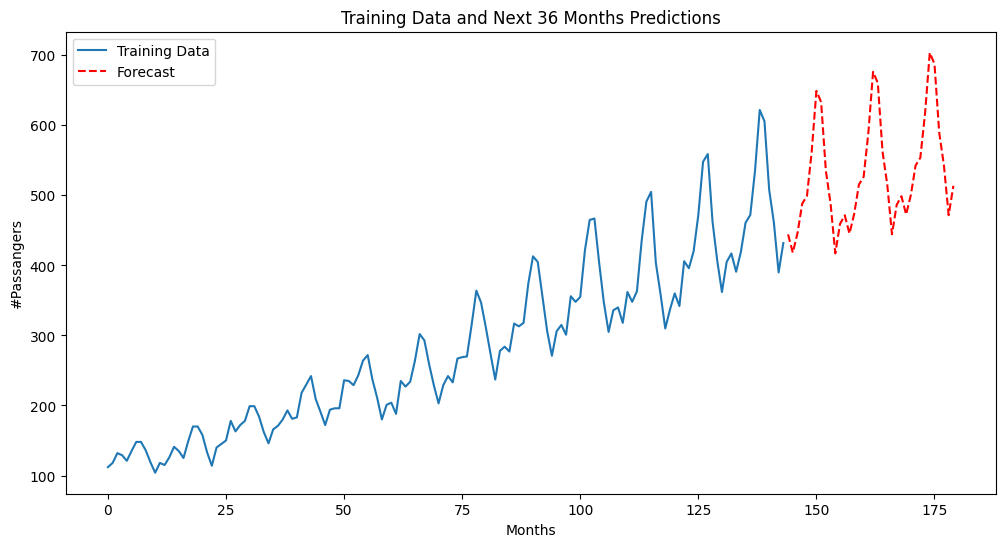

In [26]:
# Plotting training data and forecast of next 3 years
plt.figure(figsize=(12, 6))
plt.plot(np.arange(len(series)), series, label='Training Data')
plt.plot(np.arange(len(series), len(series) + len(forecast)), forecast, label='Forecast', linestyle='--', color='red')
#plt.fill_between(np.arange(len(y), len(y) + len(forecast)), conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.2, label='95% Confidence Interval')
plt.title('Training Data and Next 36 Months Predictions')
plt.xlabel('Months')
plt.ylabel('#Passangers')  
plt.legend()
plt.show()